STAT 453: Deep Learning (Spring 2021)  

Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

In [86]:
#%load_ext watermark
#%watermark -a 'Sebastian Raschka' -v -p torch

- Runs on CPU or GPU (if available)

# L03: Perceptrons

Implementation of the classic Perceptron by Frank Rosenblatt for binary classification (here: 0/1 class labels) in PyTorch

## Imports

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

## Preparing a toy dataset

In [88]:
##########################
### DATASET
##########################

data = np.genfromtxt('ALE_SensorNodeLocalizationfinal.txt', delimiter='\t')

X, y = data[:, :2], data[:, 5]
print(X)
y = y.astype(np.int)

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:80]], X[shuffle_idx[80:]]
y_train, y_test = y[shuffle_idx[:80]], y[shuffle_idx[80:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

[[30. 15.]
 [15. 15.]
 [30. 15.]
 [15. 20.]
 [30. 15.]
 [22. 18.]
 [18. 23.]
 [10. 25.]
 [29. 25.]
 [20. 20.]
 [15. 20.]
 [18. 23.]
 [18. 23.]
 [30. 15.]
 [30. 20.]
 [22. 18.]
 [14. 17.]
 [15. 15.]
 [14. 17.]
 [15. 20.]
 [15. 15.]
 [15. 20.]
 [20. 20.]
 [30. 15.]
 [20. 20.]
 [27. 12.]
 [20. 20.]
 [15. 15.]
 [30. 20.]
 [14. 17.]
 [30. 15.]
 [30. 15.]
 [15. 15.]
 [30. 15.]
 [18. 23.]
 [15. 15.]
 [15. 15.]
 [14. 17.]
 [15. 20.]
 [20. 20.]
 [15. 16.]
 [10. 25.]
 [30. 15.]
 [15. 20.]
 [15. 15.]
 [30. 15.]
 [30. 15.]
 [30. 20.]
 [15. 15.]
 [30. 20.]
 [30. 20.]
 [22. 18.]
 [15. 15.]
 [15. 20.]
 [30. 15.]
 [28. 15.]
 [20. 20.]
 [18. 23.]
 [15. 15.]
 [26. 25.]
 [29. 25.]
 [30. 20.]
 [15. 20.]
 [14. 17.]
 [15. 20.]
 [30. 20.]
 [30. 15.]
 [14. 17.]
 [15. 15.]
 [15. 15.]
 [30. 15.]
 [30. 15.]
 [15. 15.]
 [20. 20.]
 [15. 15.]
 [15. 20.]
 [15. 15.]
 [15. 15.]
 [15. 15.]
 [15. 15.]
 [15. 15.]
 [30. 20.]
 [30. 15.]
 [30. 15.]
 [15. 15.]
 [30. 15.]
 [15. 20.]
 [22. 18.]
 [15. 16.]
 [22. 18.]
 [15. 20.]

C:\Users\lawve\AppData\Local\Temp\ipykernel_33748\2734404202.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.int)


In [89]:
X_test

array([[ 1.45100379,  0.66138428],
       [ 1.45100379, -0.97166332],
       [-0.78992871, -0.6450538 ],
       [-0.04295121,  0.66138428],
       [-0.78992871,  0.66138428],
       [ 0.25583979,  0.00816524],
       [-0.34174221,  1.64121284],
       [-0.78992871, -0.97166332],
       [-0.78992871,  0.66138428],
       [-0.78992871, -0.97166332],
       [-0.78992871, -0.97166332],
       [ 1.45100379, -0.97166332],
       [-0.78992871,  0.66138428],
       [-0.93932421, -0.31844428],
       [ 1.30160829,  2.29443187],
       [-0.78992871, -0.6450538 ],
       [-0.78992871, -0.97166332],
       [ 1.45100379,  0.66138428],
       [-0.78992871, -0.97166332],
       [ 1.45100379,  0.66138428],
       [-0.34174221,  1.64121284],
       [ 1.45100379, -0.97166332],
       [ 1.45100379, -0.97166332],
       [-0.78992871, -0.97166332],
       [ 1.45100379, -0.97166332],
       [ 1.00281729, -1.95149188],
       [-0.04295121,  0.66138428]])

In [90]:
y_train

array([0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1])

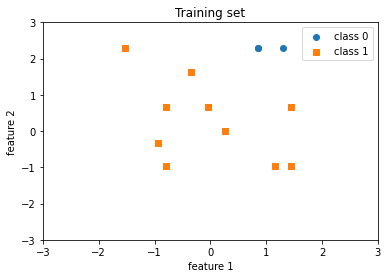

In [91]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.title('Training set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

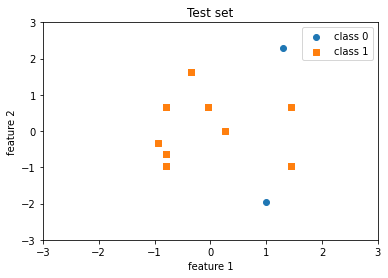

In [92]:
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')
plt.title('Test set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

## Defining the Perceptron model

In [93]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)
        
        # placeholder vectors so they don't
        # need to be recreated each time
        self.ones = torch.ones(1).to('cuda')  #Ahmed: added to.('cuda') to send tensors used in prediction to GPU device
        self.zeros = torch.zeros(1).to('cuda')

    def forward(self, x):
        linear = torch.mm(x, self.weights) + self.bias
        print(linear)
        predictions = torch.where(linear > 0., self.ones, self.zeros)
        return predictions
        
    def backward(self, x, y):  
        predictions = self.forward(x)
        errors = y - predictions
        return errors
        
    def train(self, x, y, epochs):
        for e in range(epochs):
            
            for i in range(y.shape[0]):
                # use view because backward expects a matrix (i.e., 2D tensor)
                errors = self.backward(x[i].reshape(1, self.num_features), y[i]).reshape(-1)
                self.weights += (errors * x[i]).reshape(self.num_features, 1)
                self.bias += errors
                
    def evaluate(self, x, y):
        predictions = self.forward(x).reshape(-1)
        accuracy = torch.sum(predictions == y).float() / y.shape[0]
        return accuracy

## Training the Perceptron

In [94]:
ppn = Perceptron(num_features=2)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

ppn.train(X_train_tensor, y_train_tensor, epochs=100)

print('Model parameters:')
print('  Weights: %s' % ppn.weights)
print('  Bias: %s' % ppn.bias)

tensor([[0.]], device='cuda:0')
tensor([[0.]], device='cuda:0')
tensor([[0.]], device='cuda:0')
tensor([[-0.0535]], device='cuda:0')
tensor([[-0.7888]], device='cuda:0')
tensor([[1.2726]], device='cuda:0')
tensor([[3.2607]], device='cuda:0')
tensor([[-0.7888]], device='cuda:0')
tensor([[2.0614]], device='cuda:0')
tensor([[2.0614]], device='cuda:0')
tensor([[1.4714]], device='cuda:0')
tensor([[-1.0839]], device='cuda:0')
tensor([[0.0321]], device='cuda:0')
tensor([[-0.1281]], device='cuda:0')
tensor([[0.1988]], device='cuda:0')
tensor([[-2.1768]], device='cuda:0')
tensor([[-1.6701]], device='cuda:0')
tensor([[0.0695]], device='cuda:0')
tensor([[0.2859]], device='cuda:0')
tensor([[-3.1582]], device='cuda:0')
tensor([[-0.5989]], device='cuda:0')
tensor([[1.1136]], device='cuda:0')
tensor([[1.6492]], device='cuda:0')
tensor([[-3.1661]], device='cuda:0')
tensor([[0.2760]], device='cuda:0')
tensor([[1.2884]], device='cuda:0')
tensor([[-1.6539]], device='cuda:0')
tensor([[-1.6539]], device='c

## Evaluating the model

In [95]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

tensor([[0.7271],
        [1.2471],
        [1.2394],
        [0.7912],
        [0.8233],
        [0.9864],
        [0.4920],
        [1.3434],
        [0.8233],
        [1.3434],
        [1.3434],
        [1.2471],
        [0.8233],
        [1.1418],
        [0.2134],
        [1.2394],
        [1.3434],
        [0.7271],
        [1.3434],
        [0.7271],
        [0.4920],
        [1.2471],
        [1.2471],
        [1.3434],
        [1.2471],
        [1.5784],
        [0.7912]], device='cuda:0')
Test set accuracy: 66.67%


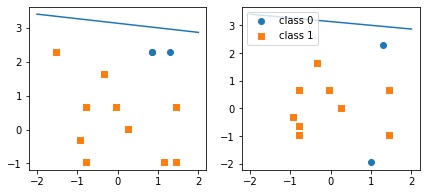

In [96]:
##########################
### 2D Decision Boundary
##########################

w, b = ppn.weights.cpu(), ppn.bias.cpu()  #Ahmed: used .cpu() to send tensors from device to CPU

x0_min = -2
x1_min = ( (-(w[0] * x0_min) - b[0]) 
          / w[1] )

x0_max = 2
x1_max = ( (-(w[0] * x0_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x0_min, x0_max], [x1_min, x1_max])
ax[1].plot([x0_min, x0_max], [x1_min, x1_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()